In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='')

In [22]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-06-01         31.26  321.500
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031


In [23]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]
    
    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today
    
    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-06-01         31.26  321.500  31.603325
2025-07-01         31.35  322.132  31.632132
2025-08-01         31.45  323.364  31.612130
2025-09-01         31.52  324.368  31.584426
2025-11-01         31.73  325.031  31.730000


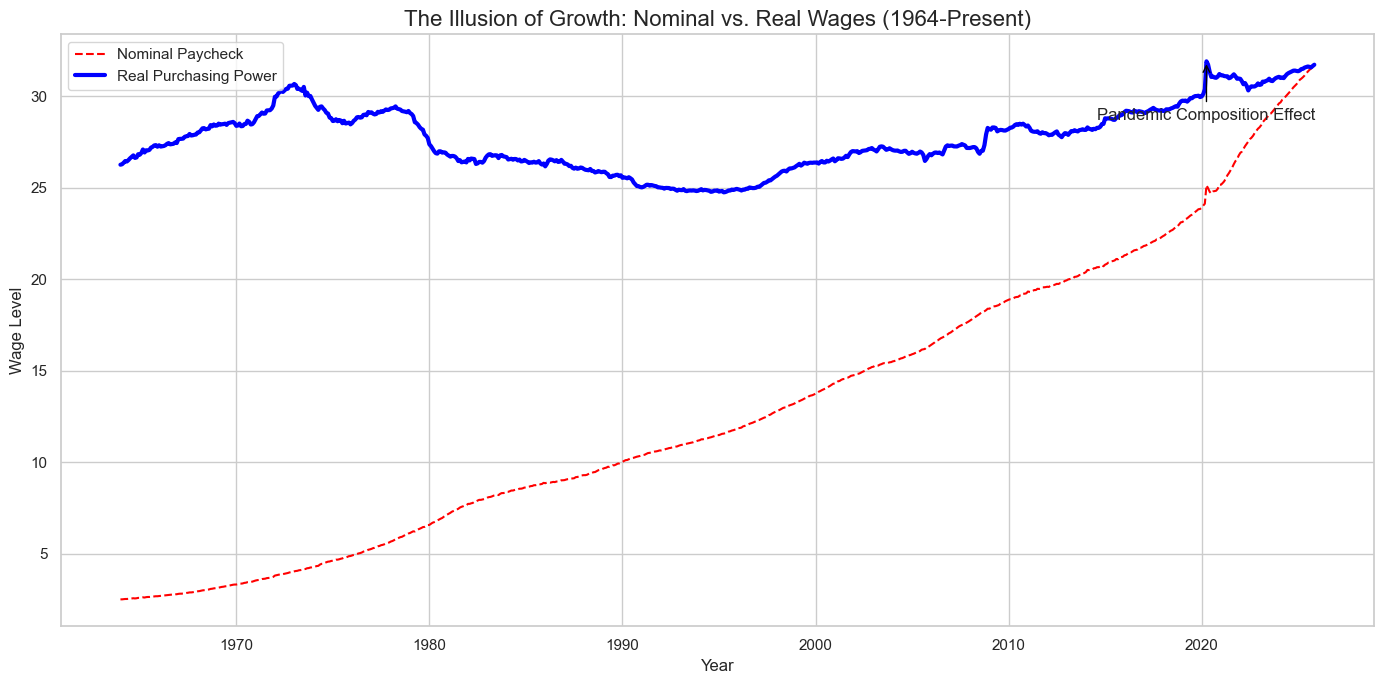

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(14, 7))

# Plot Nominal and Real Wages
plt.plot(
    df.index,
    df["Nominal_Wage"],
    linestyle="--",
    color="red",
    label="Nominal Paycheck"
)

plt.plot(
    df.index,
    df["Real_Wage"],
    linewidth=3,
    color="blue",
    label="Real Purchasing Power"
)

# Title and labels
plt.title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Wage Level")

# --- Annotation for 2020 spike in Real Wages ---
# Isolate 2020 data and find the spike
real_2020 = df.loc["2020", "Real_Wage"]
spike_date = real_2020.idxmax()
spike_value = real_2020.max()

plt.annotate(
    "Pandemic Composition Effect",
    xy=(spike_date, spike_value),
    xytext=(spike_date, spike_value * 0.9),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=12,
    ha="center"
)

# Legend
plt.legend()

# Tight layout for clean spacing
plt.tight_layout()

plt.show()


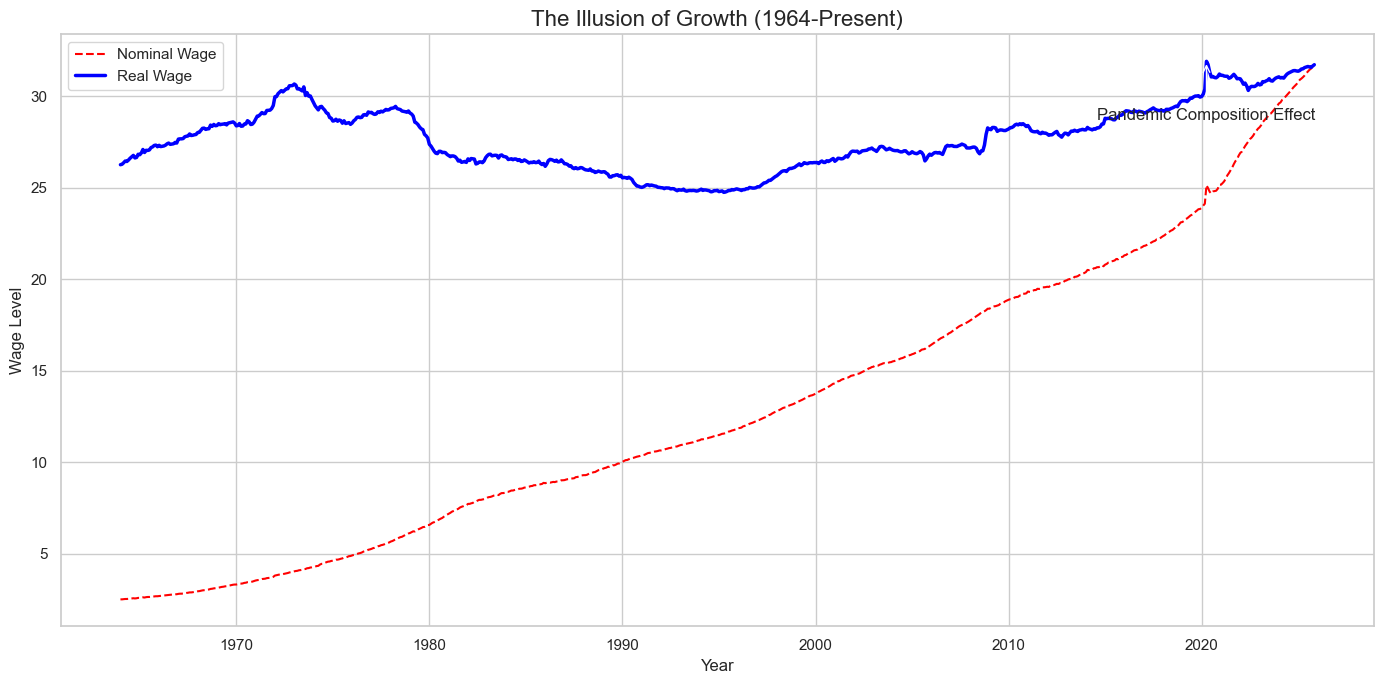

In [25]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(14, 7))

# Plot the two wage series
plt.plot(
    df.index,
    df["Nominal_Wage"],
    linestyle="--",
    color="red",
    label="Nominal Wage"
)

plt.plot(
    df.index,
    df["Real_Wage"],
    linestyle="-",
    color="blue",
    linewidth=2.5,
    label="Real Wage"
)

# Title and labels
plt.title("The Illusion of Growth (1964-Present)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Wage Level")

# --- Annotate the 2020 spike in Real Wages ---
real_2020 = df.loc["2020", "Real_Wage"]
spike_date = real_2020.idxmax()
spike_value = real_2020.max()

plt.annotate(
    "Pandemic Composition Effect",
    xy=(spike_date, spike_value),
    xytext=(spike_date, spike_value * 0.9),
    arrowprops=dict(arrowstyle="->"),
    fontsize=12,
    ha="center"
)

# Legend and layout
plt.legend()
plt.tight_layout()

plt.show()


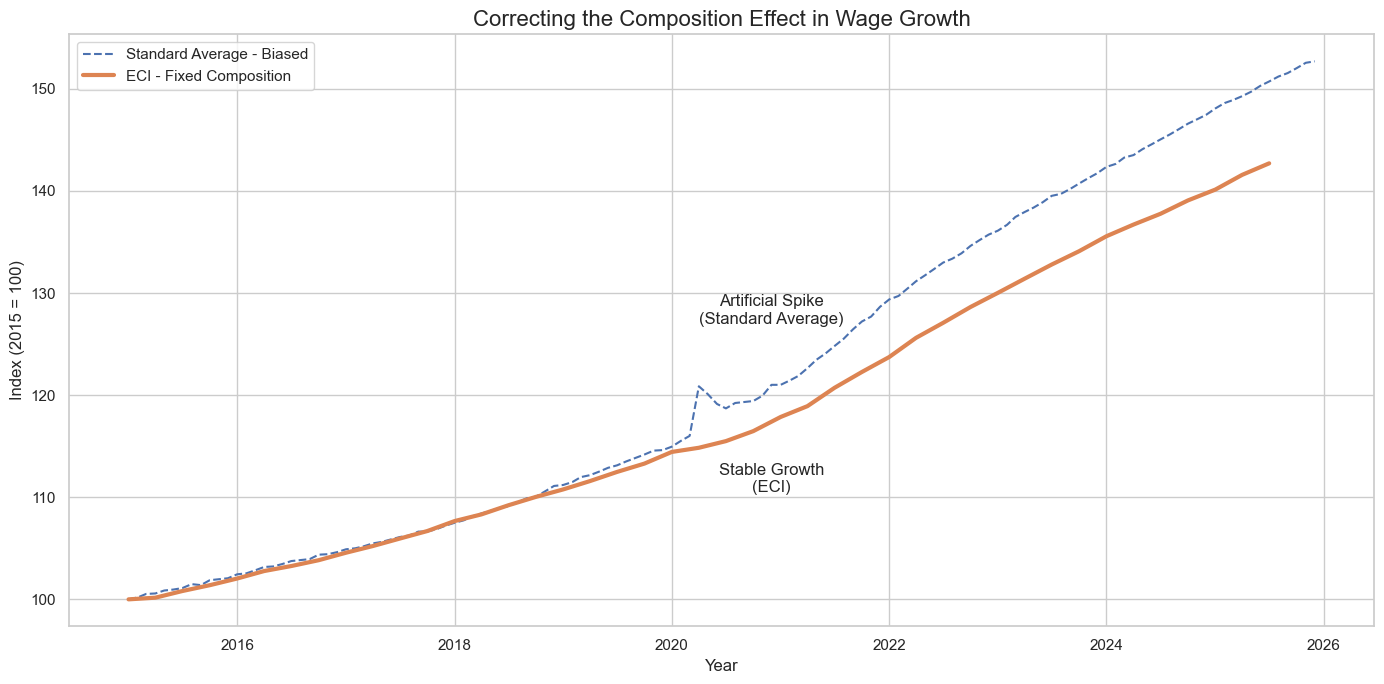

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Fetch Employment Cost Index (ECI) series
eci = fred.get_series("ECIWAG")

# Ensure datetime index
eci.index = pd.to_datetime(eci.index)
wages.index = pd.to_datetime(wages.index)

# 2. Filter both series from 2015-01-01 onward
start_date = "2015-01-01"
wages_f = wages.loc[start_date:]
eci_f = eci.loc[start_date:]

# 3. Rebase both series to 100
wages_rebased = (wages_f / wages_f.iloc[0]) * 100
eci_rebased = (eci_f / eci_f.iloc[0]) * 100

# 4. Plot
plt.figure(figsize=(14, 7))

plt.plot(
    wages_rebased.index,
    wages_rebased,
    linestyle="--",
    label="Standard Average - Biased"
)

plt.plot(
    eci_rebased.index,
    eci_rebased,
    linewidth=3,
    label="ECI - Fixed Composition"
)

# Title and labels
plt.title("Correcting the Composition Effect in Wage Growth", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Index (2015 = 100)")

# 5. Annotate 2020 divergence
w_2020 = wages_rebased.loc["2020"]
e_2020 = eci_rebased.loc["2020"]

w_spike_date = w_2020.idxmax()
w_spike_val = w_2020.max()

# Find closest ECI observation to the wage spike date
closest_eci_date = e_2020.index.get_indexer(
    [w_spike_date], method="nearest"
)[0]

e_val_2020 = e_2020.iloc[closest_eci_date]

plt.annotate(
    "Artificial Spike\n(Standard Average)",
    xy=(w_spike_date, w_spike_val),
    xytext=(w_spike_date, w_spike_val + 6),
    arrowprops=dict(arrowstyle="->"),
    ha="center"
)

plt.annotate(
    "Stable Growth\n(ECI)",
    xy=(w_spike_date, e_val_2020),
    xytext=(w_spike_date, e_val_2020 - 6),
    arrowprops=dict(arrowstyle="->"),
    ha="center"
)

plt.legend()
plt.tight_layout()
plt.show()
